In [12]:
!pip show torch

Name: torch
Version: 1.9.0+cu102
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: d:\download\anaconda\envs\pytorch\lib\site-packages
Requires: typing-extensions
Required-by: torchvision, torchaudio


In [1]:
import torch
import numpy as np
import random
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import pandas
import time

In [2]:
## 划分数据集
def sliding_window(seq,window_size):
    result=[]
    for i in range(len(seq)-window_size):
        result.append(seq[i:i+window_size])
    return result


train_path="./volume_train.npz"
test_path="./volume_test.npz"

volume_train=np.load(open(train_path,'rb'))["volume"]
volume_test=np.load(open(test_path,'rb'))["volume"]

print(volume_train.shape)  # 1920个时间段，10*20个区域，2个特征(入流量+出流量)
print(volume_test.shape)
"""
: 取1920个时间段数据
0:1  取的10*20的网格的第一行数据
0:1  取的是20的路口的第一个路口数据 
0:1  取得是每个路口的入流量
"""
volume_train=volume_train[:,0:1,0:1,0:1]
print("volume_train:",volume_train[0])
# print(volume_train[:,:,:,:])
volume_test=volume_test[:,0:1,0:1,0:1]
print(volume_train.shape)  # 
print(volume_test.shape)
## 归一化
dmin,dmax=volume_train.min(),volume_train.max()
volume_train=(volume_train-dmin)/(dmax-dmin)

dmin,dmax=volume_test.min(),volume_test.max()
volume_test=(volume_test-dmin)/(dmax-dmin)


## 滑动窗口划分
train_set,test_set = [],[]  
for  i in range(1) :  
    train_seq = volume_train[:,:,:,:]  
    test_seq = volume_test[:,:,:,:]  
    ## 将长序列划分为若干个长度为6的短序列
    train_set += sliding_window(train_seq,window_size=7)  
    test_set += sliding_window(test_seq,window_size=7)  
train_set,test_set= np.array(train_set).squeeze(), np.array(test_set).squeeze()  
print(train_set.shape,test_set.shape)    
print(train_set,test_set)                

(1920, 10, 20, 2)
(960, 10, 20, 2)
volume_train: [[[64.]]]
(1920, 1, 1, 1)
(960, 1, 1, 1)
(1913, 7) (953, 7)


### 数据归一化：
1. min-max标准化  

$ x'=x-min/max-min $ 

这种方法有个缺陷就是当有新数据加入时，可能导致max和min的变化，需要重新定义。

2. Z-score 标准化方法

$ x'=x-u/q $

https://blog.csdn.net/haoji007/article/details/81157224

### 模型优化

In [3]:
device = 'cuda'  
model = nn.RNN(input_size=1, hidden_size=32, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(32, 1), nn.LeakyReLU()).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(list(model.parameters()) + list(out_linear.parameters()), lr=0.0001)

### map函数

In [4]:
def mape(y_true, y_pred):  
    y_true, y_pred = np.array(y_true), np.array(y_pred)  
    non_zero_index = (y_true > 0)  
    y_true = y_true[non_zero_index]  
    y_pred = y_pred[non_zero_index]  
  
    mape = np.abs((y_true - y_pred) / y_true)  
    mape[np.isinf(mape)] = 0  
    return np.mean(mape) * 100  

### next_batch函数

In [5]:
def next_batch(data, batch_size):  
    data_length = len(data)  
    num_batches = math.ceil(data_length / batch_size)  
    for batch_index in range(num_batches):  
        start_index = batch_index * batch_size  
        end_index = min((batch_index + 1) * batch_size, data_length)  
        yield data[start_index:end_index]

### 开始训练

In [6]:
from sklearn.utils import shuffle 
import math 
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data
from PIL import Image 
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

In [7]:
train_log = []
test_log = []

#开始时间
timestart = time.time()
trained_batches = 0 #记录多少个batch 
for epoch in range(100):
    total_1oss = 0 #记录Loss
    for batch in next_batch(shuffle(train_set), batch_size=128):  # 每次取128个短序列
        #每一个batch的开始时间
        batchstart = time.time()
        
        batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
        # 使用短序列的前6个值作为历史，最后一个值作为预测值。
        x, label = batch[:, :6], batch[:, -1]
        out, hidden = model(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
        out = out_linear(out[:, -1, :])
        prediction = out.squeeze(-1)  # (batch)
        
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
     
        #累加loss
        total_1oss += loss.item( )
        trained_batches += 1
    
        train_log.append(loss.detach().cpu().numpy().tolist());
        train_batch_time = (time.time() - batchstart)
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time))
       
        
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        if trained_batches % 100 == 0:
            #每一个batch的开始时间
            batch_test_start = time.time()
            #在每个epoch上测试
            all_prediction = []
            for batch in next_batch(test_set, batch_size=128):
                batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
                x, label = batch[:, :6], batch[:, -1]
                out, hidden = model(x.unsqueeze(-1))  # out: (batch_size, seq_len, hidden_size)
                out = out_linear(out[:, -1, :])
                prediction = out.squeeze(-1)  # (batch)
                all_prediction.append(prediction.detach().cpu().numpy())

            all_prediction = np.concatenate(all_prediction)
            all_label = test_set[:, -1]
            # 没有进行反归一化操作。
            #all_prediction = denormalize(all_prediction)
            #all_label = denormalize(all_label)
            # 计算测试指标。
            rmse_score = math.sqrt(mse(all_label, all_prediction))
            mae_score = mae(all_label, all_prediction)
            mape_score = mape(all_label, all_prediction)
            test_log.append([rmse_score, mae_score, mape_score])
            test_batch_time = (time.time() - batch_test_start)
            print('test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time))

        #每一个epoch的结束时间
        #elapsed = (time.time() - epochstart)
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed))
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed),file=f)
    
#计算总时间
timesum = (time.time() - timestart)
print('The total time is %fs'%(timesum))

batch 1, train_loss 0.075954,Time used 0.583888s
batch 2, train_loss 0.073781,Time used 0.002992s
batch 3, train_loss 0.078928,Time used 0.002992s
batch 4, train_loss 0.078714,Time used 0.002992s
batch 5, train_loss 0.068961,Time used 0.002992s
batch 6, train_loss 0.064772,Time used 0.001995s
batch 7, train_loss 0.073495,Time used 0.002992s
batch 8, train_loss 0.061305,Time used 0.002992s
batch 9, train_loss 0.080388,Time used 0.002992s
batch 10, train_loss 0.067506,Time used 0.001994s
batch 11, train_loss 0.074622,Time used 0.002993s
batch 12, train_loss 0.059457,Time used 0.002992s
batch 13, train_loss 0.052891,Time used 0.001994s
batch 14, train_loss 0.061801,Time used 0.001994s
batch 15, train_loss 0.061977,Time used 0.002992s
batch 16, train_loss 0.050851,Time used 0.002992s
batch 17, train_loss 0.074433,Time used 0.002992s
batch 18, train_loss 0.059687,Time used 0.001994s
batch 19, train_loss 0.065221,Time used 0.001995s
batch 20, train_loss 0.050544,Time used 0.002992s
batch 21,

batch 199, train_loss 0.029854,Time used 0.002993s
batch 200, train_loss 0.030477,Time used 0.002991s
test_batch 200, test_rmse_loss 0.192065,test_mae_loss 0.165361,test_mape_loss 155.828662,Time used 0.005984s
batch 201, train_loss 0.036995,Time used 0.001994s
batch 202, train_loss 0.034630,Time used 0.001994s
batch 203, train_loss 0.033481,Time used 0.001994s
batch 204, train_loss 0.035987,Time used 0.002992s
batch 205, train_loss 0.036723,Time used 0.001995s
batch 206, train_loss 0.032260,Time used 0.002992s
batch 207, train_loss 0.032080,Time used 0.001994s
batch 208, train_loss 0.038406,Time used 0.002993s
batch 209, train_loss 0.033647,Time used 0.001994s
batch 210, train_loss 0.036475,Time used 0.002994s
batch 211, train_loss 0.037707,Time used 0.002992s
batch 212, train_loss 0.032117,Time used 0.002991s
batch 213, train_loss 0.029856,Time used 0.002992s
batch 214, train_loss 0.031663,Time used 0.002992s
batch 215, train_loss 0.035184,Time used 0.002991s
batch 216, train_loss 0.

batch 391, train_loss 0.023689,Time used 0.002990s
batch 392, train_loss 0.022065,Time used 0.002991s
batch 393, train_loss 0.021224,Time used 0.002992s
batch 394, train_loss 0.021971,Time used 0.002993s
batch 395, train_loss 0.021055,Time used 0.002993s
batch 396, train_loss 0.016921,Time used 0.002991s
batch 397, train_loss 0.022571,Time used 0.002990s
batch 398, train_loss 0.018537,Time used 0.002992s
batch 399, train_loss 0.022380,Time used 0.003081s
batch 400, train_loss 0.020231,Time used 0.002903s
test_batch 400, test_rmse_loss 0.152909,test_mae_loss 0.119357,test_mape_loss 89.122900,Time used 0.004983s
batch 401, train_loss 0.025879,Time used 0.001994s
batch 402, train_loss 0.023795,Time used 0.002992s
batch 403, train_loss 0.016459,Time used 0.002992s
batch 404, train_loss 0.020630,Time used 0.002991s
batch 405, train_loss 0.015817,Time used 0.002992s
batch 406, train_loss 0.023942,Time used 0.002992s
batch 407, train_loss 0.020620,Time used 0.001994s
batch 408, train_loss 0.0

batch 594, train_loss 0.020962,Time used 0.003995s
batch 595, train_loss 0.017866,Time used 0.002988s
batch 596, train_loss 0.015164,Time used 0.003988s
batch 597, train_loss 0.014367,Time used 0.002992s
batch 598, train_loss 0.014678,Time used 0.001994s
batch 599, train_loss 0.019067,Time used 0.002992s
batch 600, train_loss 0.017676,Time used 0.002993s
test_batch 600, test_rmse_loss 0.139438,test_mae_loss 0.107980,test_mape_loss 76.630548,Time used 0.006981s
batch 601, train_loss 0.021587,Time used 0.001995s
batch 602, train_loss 0.013083,Time used 0.002992s
batch 603, train_loss 0.016401,Time used 0.003991s
batch 604, train_loss 0.013844,Time used 0.002992s
batch 605, train_loss 0.014573,Time used 0.002991s
batch 606, train_loss 0.020604,Time used 0.001994s
batch 607, train_loss 0.018291,Time used 0.002992s
batch 608, train_loss 0.020638,Time used 0.001994s
batch 609, train_loss 0.017353,Time used 0.002991s
batch 610, train_loss 0.014816,Time used 0.002993s
batch 611, train_loss 0.0

batch 791, train_loss 0.013425,Time used 0.002993s
batch 792, train_loss 0.014305,Time used 0.002990s
batch 793, train_loss 0.012465,Time used 0.002992s
batch 794, train_loss 0.012519,Time used 0.003989s
batch 795, train_loss 0.014257,Time used 0.001994s
batch 796, train_loss 0.017996,Time used 0.001995s
batch 797, train_loss 0.014371,Time used 0.002992s
batch 798, train_loss 0.015656,Time used 0.002993s
batch 799, train_loss 0.013327,Time used 0.002991s
batch 800, train_loss 0.012177,Time used 0.001994s
test_batch 800, test_rmse_loss 0.126315,test_mae_loss 0.097638,test_mape_loss 65.849413,Time used 0.005985s
batch 801, train_loss 0.012368,Time used 0.003011s
batch 802, train_loss 0.015613,Time used 0.002973s
batch 803, train_loss 0.012642,Time used 0.002991s
batch 804, train_loss 0.017343,Time used 0.002992s
batch 805, train_loss 0.013628,Time used 0.001994s
batch 806, train_loss 0.011531,Time used 0.002992s
batch 807, train_loss 0.014994,Time used 0.002992s
batch 808, train_loss 0.0

batch 986, train_loss 0.011873,Time used 0.001994s
batch 987, train_loss 0.013205,Time used 0.002994s
batch 988, train_loss 0.010574,Time used 0.002990s
batch 989, train_loss 0.011205,Time used 0.002992s
batch 990, train_loss 0.011637,Time used 0.002992s
batch 991, train_loss 0.014481,Time used 0.002993s
batch 992, train_loss 0.010187,Time used 0.002991s
batch 993, train_loss 0.011974,Time used 0.002991s
batch 994, train_loss 0.012892,Time used 0.002994s
batch 995, train_loss 0.012567,Time used 0.002991s
batch 996, train_loss 0.009682,Time used 0.002987s
batch 997, train_loss 0.011776,Time used 0.002992s
batch 998, train_loss 0.014570,Time used 0.001993s
batch 999, train_loss 0.010918,Time used 0.002993s
batch 1000, train_loss 0.013882,Time used 0.002992s
test_batch 1000, test_rmse_loss 0.115120,test_mae_loss 0.088506,test_mape_loss 54.867626,Time used 0.005984s
batch 1001, train_loss 0.011198,Time used 0.002993s
batch 1002, train_loss 0.014634,Time used 0.001994s
batch 1003, train_los

batch 1184, train_loss 0.009609,Time used 0.001993s
batch 1185, train_loss 0.009714,Time used 0.001992s
batch 1186, train_loss 0.009840,Time used 0.001994s
batch 1187, train_loss 0.010473,Time used 0.001995s
batch 1188, train_loss 0.009519,Time used 0.002992s
batch 1189, train_loss 0.010922,Time used 0.002994s
batch 1190, train_loss 0.011831,Time used 0.002992s
batch 1191, train_loss 0.010457,Time used 0.002992s
batch 1192, train_loss 0.009243,Time used 0.002991s
batch 1193, train_loss 0.012146,Time used 0.002992s
batch 1194, train_loss 0.010634,Time used 0.001995s
batch 1195, train_loss 0.011044,Time used 0.001992s
batch 1196, train_loss 0.009623,Time used 0.001995s
batch 1197, train_loss 0.013239,Time used 0.002993s
batch 1198, train_loss 0.011613,Time used 0.002991s
batch 1199, train_loss 0.012113,Time used 0.001994s
batch 1200, train_loss 0.011415,Time used 0.002992s
test_batch 1200, test_rmse_loss 0.107483,test_mae_loss 0.082993,test_mape_loss 50.269482,Time used 0.006982s
batch 1

batch 1380, train_loss 0.010440,Time used 0.002994s
batch 1381, train_loss 0.008437,Time used 0.002991s
batch 1382, train_loss 0.011491,Time used 0.001994s
batch 1383, train_loss 0.010555,Time used 0.002993s
batch 1384, train_loss 0.009753,Time used 0.002992s
batch 1385, train_loss 0.012046,Time used 0.001994s
batch 1386, train_loss 0.010375,Time used 0.003991s
batch 1387, train_loss 0.008449,Time used 0.002991s
batch 1388, train_loss 0.012060,Time used 0.002991s
batch 1389, train_loss 0.011424,Time used 0.002991s
batch 1390, train_loss 0.009449,Time used 0.002993s
batch 1391, train_loss 0.009204,Time used 0.002993s
batch 1392, train_loss 0.012939,Time used 0.002992s
batch 1393, train_loss 0.010839,Time used 0.002991s
batch 1394, train_loss 0.010428,Time used 0.001994s
batch 1395, train_loss 0.008692,Time used 0.002992s
batch 1396, train_loss 0.009054,Time used 0.002992s
batch 1397, train_loss 0.009450,Time used 0.002992s
batch 1398, train_loss 0.008824,Time used 0.002992s
batch 1399, 

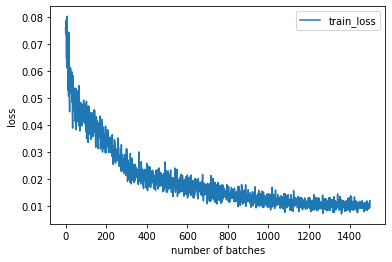

<Figure size 432x288 with 0 Axes>

In [8]:
#train_loss曲线  
x = np.linspace(0,len(train_log),len(train_log))  
plt.plot(x,train_log,label="train_loss",linewidth=1.5)  
plt.xlabel("number of batches")  
plt.ylabel("loss")  
plt.legend()  
plt.show()  
plt.savefig('train_loss.jpg')  

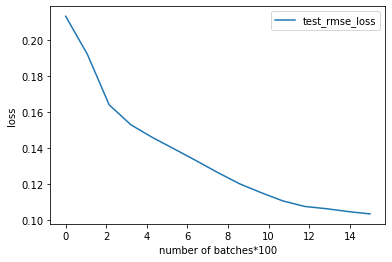

<Figure size 432x288 with 0 Axes>

In [9]:
#test_loss曲线  
x_test= np.linspace(0,len(test_log),len(test_log))  
test_log = np.array(test_log)  
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)  
plt.xlabel("number of batches*100")  
plt.ylabel("loss")  
plt.legend()  
plt.show()  
plt.savefig('test_rmse_loss.jpg')  

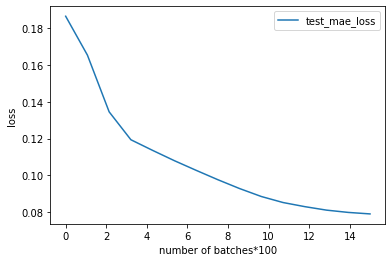

<Figure size 432x288 with 0 Axes>

In [10]:
x_test= np.linspace(0,len(test_log),len(test_log))  
test_log = np.array(test_log)  
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)  
plt.xlabel("number of batches*100")  
plt.ylabel("loss")  
plt.legend()  
plt.show()  
plt.savefig('test_mae_loss.jpg') 

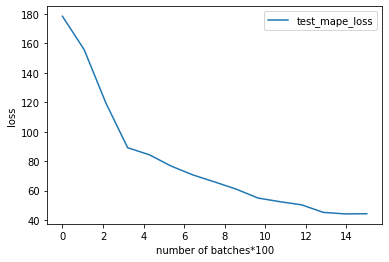

<Figure size 432x288 with 0 Axes>

In [11]:
x_test= np.linspace(0,len(test_log),len(test_log))  
test_log = np.array(test_log)  
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)  
plt.xlabel("number of batches*100")  
plt.ylabel("loss")  
plt.legend()  
plt.show()  
plt.savefig('test_mape_loss.jpg') 